In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd

import sklearn
import os
import duckdb
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Dropout, BatchNormalization, LeakyReLU, Lambda, ReLU

from keras.losses import Loss, mse, MeanSquaredError
from keras.optimizers import Optimizer, Adam
from keras.regularizers import L2
from keras.metrics import Mean, MeanAbsoluteError
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

from sklearn.dummy import DummyRegressor

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

# Geospatial 
from geopy import distance
import geopandas as gpd

np.random.seed(1234)
tf.random.set_seed(1234)

2024-05-16 12:47:40.715935: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 12:47:40.743737: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 12:47:40.743776: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 12:47:40.743806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 12:47:40.749885: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 12:47:40.750616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
df_taxi = pd.read_parquet("data/processed/yellow_taxi_2023.parquet")

In [5]:
# Xavier initializer
def xavier(shape):
    return tf.random.truncated_normal(
        shape, 
        mean=0.0,
        stddev=np.sqrt(2/sum(shape)))



class BayesianDenseLayer(tf.keras.Model):
    """A fully-connected Bayesian neural network layer
    
    Parameters
    ----------
    d_in : int
        Dimensionality of the input (# input features)
    d_out : int
        Output dimensionality (# units in the layer)
    name : str
        Name for the layer
        
    Attributes
    ----------
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the layer
    """
    
    def __init__(self, d_in, d_out, name=None):
        
        super(BayesianDenseLayer, self).__init__(name=name)
        self.d_in = d_in
        self.d_out = d_out
        
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([1, d_out])-6.0, name='b_std')
    
    
    def call(self, x, sampling=True):
        """Perform the forward pass"""
        
        if sampling:
        
            # Flipout-estimated weight samples
            s = tfp.random.rademacher(tf.shape(x))
            r = tfp.random.rademacher([x.shape[0], self.d_out])
            w_samples = tf.nn.softplus(self.w_std)*tf.random.normal([self.d_in, self.d_out])
            w_perturbations = r*tf.matmul(x*s, w_samples)
            w_outputs = tf.matmul(x, self.w_loc) + w_perturbations
            
            # Flipout-estimated bias samples
            r = tfp.random.rademacher([x.shape[0], self.d_out])
            b_samples = tf.nn.softplus(self.b_std)*tf.random.normal([self.d_out])
            b_outputs = self.b_loc + r*b_samples
            
            return w_outputs + b_outputs
        
        else:
            return x @ self.w_loc + self.b_loc
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        weight = tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
        bias = tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(bias, prior)))


In [6]:
class BayesianDenseNetwork(tf.keras.Model):
    """A multilayer fully-connected Bayesian neural network
    
    Parameters
    ----------
    dims : List[int]
        List of units in each layer
    name : str
        Name for the network
        
    Attributes
    ----------
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors, 
        over all layers in the network
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the network
    """
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseNetwork, self).__init__(name=name)
        
        self.steps = []
        self.acts = []
        for i in range(len(dims)-1):
            self.steps += [BayesianDenseLayer(dims[i], dims[i+1])]
            self.acts += [tf.nn.relu]
            
        self.acts[-1] = lambda x: x
        
    
    def call(self, x, sampling=True):
        """Perform the forward pass"""

        for i in range(len(self.steps)):
            x = self.steps[i](x, sampling=sampling)
            x = self.acts[i](x)
            
        return x
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        return tf.reduce_sum([s.losses for s in self.steps])


In [14]:
class BayesianDensityNetwork(tf.keras.Model):
    """Multilayer fully-connected Bayesian neural network, with
    two heads to predict both the mean and the standard deviation.
    
    Parameters
    ----------
    units : List[int]
        Number of output dimensions for each layer
        in the core network.
    units : List[int]
        Number of output dimensions for each layer
        in the head networks.
    name : None or str
        Name for the layer
    """
    
    
    def __init__(self, units, head_units, name=None):
        
        # Initialize
        super(BayesianDensityNetwork, self).__init__(name=name)
        
        # Create sub-networks
        self.core_net = BayesianDenseNetwork(units)
        self.loc_net = BayesianDenseNetwork([units[-1]]+head_units)
        self.std_net = BayesianDenseNetwork([units[-1]]+head_units)

    
    def call(self, x, sampling=True):
        """Pass data through the model
        
        Parameters
        ----------
        x : tf.Tensor
            Input data
        sampling : bool
            Whether to sample parameter values from their 
            variational distributions (if True, the default), or
            just use the Maximum a Posteriori parameter value
            estimates (if False).
            
        Returns
        -------
        preds : tf.Tensor of shape (Nsamples, 2)
            Output of this model, the predictions.  First column is
            the mean predictions, and second column is the standard
            deviation predictions.
        """
        
        # Pass data through core network
        x = self.core_net(x, sampling=sampling)
        x = tf.nn.relu(x)
        
        # Make predictions with each head network
        loc_preds = self.loc_net(x, sampling=sampling)
        std_preds = self.std_net(x, sampling=sampling)
        std_preds = tf.nn.softplus(std_preds)
        
        # Return mean and std predictions
        return tf.concat([loc_preds, std_preds], 1)
    
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        
        # Compute mean and std predictions
        preds = self.call(x, sampling=sampling)
        
        # Ensure consistent dtypes
        loc = tf.cast(preds[:, 0], dtype=tf.float32)
        scale = tf.cast(preds[:, 1], dtype=tf.float32)
        y = tf.cast(y[:, 0], dtype=tf.float32)
        
        # Return log likelihood of true data given predictions
        return tfd.Normal(loc, scale).log_prob(y)
        
        
    @tf.function
    def sample(self, x):
        """Draw one sample from the predictive distribution"""
        preds = self.call(x)
        return tfd.Normal(preds[:,0], preds[:,1]).sample()
    
    
    def samples(self, x, n_samples=1):
        """Draw multiple samples from predictive distributions"""
        samples = np.zeros((x.shape[0], n_samples))
        for i in range(n_samples):
            samples[:,i] = self.sample(x)
        return samples
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        return (self.core_net.losses +
                self.loc_net.losses +
                self.std_net.losses)


In [15]:
# Batch size
BATCH_SIZE = 1024

# Number of training epochs
EPOCHS = 100

# Learning rate
L_RATE = 1e-4

# Proportion of samples to hold out
VAL_SPLIT = 0.2

# Split the dataframe into dependent abd independent columns
Y_taxi = df_taxi['trip_duration'].copy()
X_taxi = df_taxi.drop('trip_duration', axis=1)

# Split data randomly into training + validation
tr_ind = np.random.choice([False, True],
                          size=X_taxi.shape[0],
                          p=[VAL_SPLIT, 1.0-VAL_SPLIT])
x_train = X_taxi[tr_ind].values
y_train = Y_taxi[tr_ind].values
x_val = X_taxi[~tr_ind].values
y_val = Y_taxi[~tr_ind].values
N_train = x_train.shape[0]
N_val = x_val.shape[0]

# Make y 2d
y_train = np.expand_dims(y_train, 1)
y_val = np.expand_dims(y_val, 1)

# Make a TensorFlow Dataset from training data
data_train = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

# Make a TensorFlow Dataset from validation data
data_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(N_val)


2024-05-10 11:10:11.449104: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65562504 exceeds 10% of free system memory.


In [16]:

# Instantiate the model
model2 = BayesianDensityNetwork([7, 256, 128], [64, 32, 1])
# Use the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=L_RATE)

N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_likelihoods = model2.log_likelihood(x_data, y_data)
        kl_loss = model2.losses
        elbo_loss = kl_loss/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model2.trainable_variables))
    return elbo_loss

# Fit the model
elbo2 = np.zeros(EPOCHS)
mae2 = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        elbo2[epoch] += train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model2(x_data, sampling=False)[:, 0]
        mae2[epoch] = mean_absolute_error(y_pred, y_data)


2024-05-10 11:10:13.964646: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65562504 exceeds 10% of free system memory.
2024-05-10 11:10:35.896227: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 299719680 exceeds 10% of free system memory.


In [ ]:
elbo2

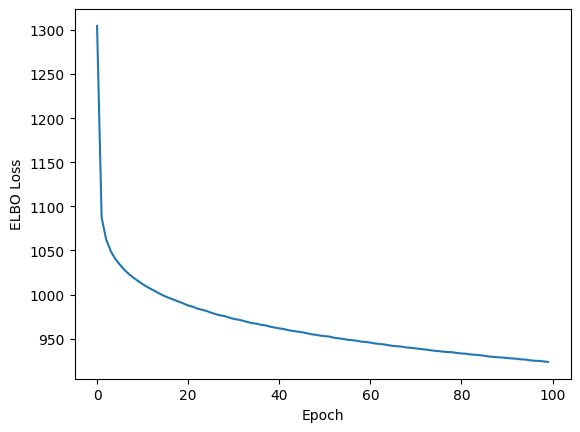

In [17]:
# Plot the ELBO Loss over training
plt.plot(elbo2)
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.show()


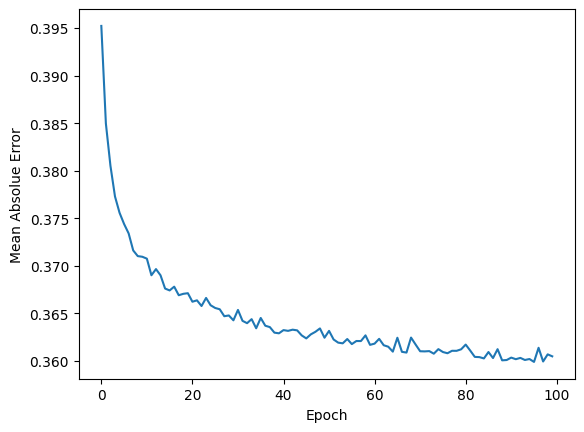

In [18]:
# Plot error over training
plt.plot(mae2)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolue Error')
plt.show()


# Test

In [8]:
class DenseFlipout(tf.keras.Model):
    
    def __init__(self, units, name=None):
        
        super(DenseFlipout, self).__init__(name=name)
        self.units = units
    
    # Xavier initializer
    def xavier(self, shape):
        return tf.random.truncated_normal(
            shape, 
            mean=0.0,
            stddev=np.sqrt(2/sum(shape)))
        
    def build(self, input_shape):

        self.d_in = input_shape[-1]
        # Initializing mean and standard deviation for weights and biases to represent their posterior distributions.
        self.w_loc = tf.Variable(self.xavier((self.d_in, self.units)), name='w_loc')
        self.w_std = tf.Variable(self.xavier((self.d_in, self.units)) - 6.0, name='w_std')
        self.b_loc = tf.Variable(self.xavier((1, self.units)), name='b_loc')
        self.b_std = tf.Variable(self.xavier((1, self.units)) - 6.0, name='b_std')
    
    def call(self, x, sampling=True):
        
        if sampling:
        
            # Flipout-estimated weight samples
            s = tfp.random.rademacher(tf.shape(x))
            r = tfp.random.rademacher([tf.shape(x)[0], self.units])
            w_samples = tf.nn.softplus(self.w_std)*tf.random.normal([self.d_in, self.units])
            w_perturbations = r*tf.matmul(x*s, w_samples)
            w_outputs = tf.matmul(x, self.w_loc) + w_perturbations
            
            # Flipout-estimated bias samples
            r = tfp.random.rademacher([tf.shape(x)[0], self.units])
            b_samples = tf.nn.softplus(self.b_std)*tf.random.normal([self.units])
            b_outputs = self.b_loc + r*b_samples
            
            return w_outputs + b_outputs
        
        else:
            return x @ self.w_loc + self.b_loc
    
    
    
    @property
    def layer_loss(self):
        
        weight = tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
        bias = tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(bias, prior)))


In [9]:
class BayesianNN(tf.keras.Model):

    def __init__(self,
                 layer_units: list = [5, 5],
                 output_unit: int = 1,
                 name = "BayesianNN"):
        
        super(BayesianNN, self).__init__(name=name)
        
        self.layer_units = layer_units
        self.output_unit = output_unit

        self.custom_layers = []
        self.activations = []
        for i in range(len(layer_units)):
            self.custom_layers += [ DenseFlipout( units=layer_units[i],
                                               name='DenseVariational_{}'.format(i)
                                               )]
            self.activations.append(tf.nn.relu)
            
        self.custom_layers += [ DenseFlipout(  units = self.output_unit,
                                            name = 'OutputLayer'
                                            )]
        self.activations.append(lambda x: x)
    
    def call(self, x, sampling=True):
        """Perform the forward pass"""

        for i in range(len(self.custom_layers)):
            x = self.custom_layers[i](x, sampling=sampling)
            x = self.activations[i](x)
            
        return x
    
    
    @property
    def network_loss(self):
        """Sum of the KL divergences between priors + posteriors"""
        return tf.reduce_sum([layer.layer_loss for layer in self.custom_layers])


In [130]:
class BayesianNN2Heads(tf.keras.Model):
    
    def __init__(self, core_units, head_units, name=None):
        
        # Initialize
        super(BayesianNN2Heads, self).__init__(name=name)
        
        # Trackers for training metrics
        self.train_elbo_tracker = Mean(name='train_elbo')
        self.train_mae_tracker = MeanAbsoluteError(name='train_mae')

        # Trackers for validation metrics
        self.val_elbo_tracker = Mean(name='val_elbo')
        self.val_mae_tracker = MeanAbsoluteError(name='val_mae')
        
        
        
        
        # Create the core network using BayesianNN
        self.core_net = BayesianNN( layer_units = core_units[:-1], 
                                    output_unit = core_units[-1]) 
        
        # Create the loc(mean) head network
        self.loc_net = BayesianNN(  layer_units = [core_units[-1]] + head_units[:-1], 
                                    output_unit = head_units[-1])    

        # Create the scale (standard deviation) head network
        self.std_net = BayesianNN(  layer_units = [core_units[-1]] + head_units[:-1], 
                                    output_unit = head_units[-1])
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) 
    
    def call(self, x, sampling=True):
        
        # Pass data through core network
        x = self.core_net(x, sampling=sampling)
        x = tf.nn.relu(x)
        
        # Make predictions with each head network
        loc_preds = self.loc_net(x, sampling=sampling)
        std_preds = self.std_net(x, sampling=sampling)
        std_preds = tf.nn.softplus(std_preds)
        
        # Return mean and std predictions
        return tf.concat([loc_preds, std_preds], 1)
    
    def train_step(self, data):
        x, y = data
        elbo_loss = self._train_evaluate(x, y)
        self.train_elbo_tracker.update_state(elbo_loss) 

        dict_losses = {  "train_elbo":self.train_elbo_tracker.result()}
        return dict_losses
    
    @tf.function
    def _train_evaluate(self, x, y):
        N = tf.shape(x)[0]
        with tf.GradientTape() as tape:
            log_likelihoods  = self.log_likelihood(x, y)
            # List of losses
            total_kl_loss = self.losses
            elbo_loss = total_kl_loss/tf.cast(N, tf.float32)  - tf.reduce_mean(log_likelihoods)

        grads = tape.gradient(elbo_loss, self.trainable_weights) 
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))       
             
        return elbo_loss
    
    @tf.function
    def test_step(self, data):
        x, y = data
        preds = self.call(x, sampling = False)    
        y_loc_pred = preds[:, 0]
        
        self.val_mae_tracker.update_state(y, y_loc_pred)
        dict_losses = { "mae": self.val_mae_tracker.result()}
        return dict_losses
    
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        
        # Compute mean and std predictions
        preds = self.call(x, sampling=sampling)
        
        # Ensure consistent dtypes
        loc = tf.cast(preds[:, 0], dtype=tf.float32)
        scale = tf.cast(preds[:, 1], dtype=tf.float32)
        y = tf.cast(y[:, 0], dtype=tf.float32)
        
        log_likelihood = tfd.Normal(loc, scale).log_prob(y)
        # Return log likelihood of true data given predictions
        return log_likelihood
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        return (self.core_net.losses +
                self.loc_net.losses +
                self.std_net.losses)

In [12]:
class BayesianNN2Heads(tf.keras.Model):
    
    def __init__(self, core_units, head_units, name=None):
        
        # Initialize
        super(BayesianNN2Heads, self).__init__(name=name)
            
        # Create the core network using BayesianNN
        self.core_net = BayesianNN( layer_units = core_units[:-1], 
                                    output_unit = core_units[-1]) 
        
        # Create the loc(mean) head network
        self.loc_net = BayesianNN(  layer_units = [core_units[-1]] + head_units[:-1], 
                                    output_unit = head_units[-1])    

        # Create the scale (standard deviation) head network
        self.std_net = BayesianNN(  layer_units = [core_units[-1]] + head_units[:-1], 
                                    output_unit = head_units[-1])
    
    def call(self, x, sampling=True):
        
        # Pass data through core network
        x = self.core_net(x, sampling=sampling)
        x = tf.nn.relu(x)
        
        # Make predictions with each head network
        loc_preds = self.loc_net(x, sampling=sampling)
        std_preds = self.std_net(x, sampling=sampling)
        std_preds = tf.nn.softplus(std_preds)
        
        # Return mean and std predictions
        return tf.concat([loc_preds, std_preds], 1)
    
    @tf.function
    def _train_evaluate(self, x, y, optimizer, N):
        #N = tf.cast(tf.shape(x)[0], tf.float32)
        with tf.GradientTape() as tape:
            log_likelihoods  = self.log_likelihood(x, y)
            total_kl_loss = self.kl_loss
            elbo_loss = total_kl_loss/N  - tf.reduce_mean(log_likelihoods)
            tf.print("\n elbo:", elbo_loss)
            tf.print("\n log_likelihoods reduce:", tf.reduce_mean(log_likelihoods))

        grads = tape.gradient(elbo_loss, self.trainable_weights) 
        optimizer.apply_gradients(zip(grads, self.trainable_weights))       
             
        return elbo_loss  
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        
        # Compute mean and std predictions
        preds = self.call(x, sampling=sampling)
        
        # Ensure consistent dtypes
        loc = tf.cast(preds[:, 0], dtype=tf.float32)
        scale = tf.cast(preds[:, 1], dtype=tf.float32)
        y = tf.cast(y[:, 0], dtype=tf.float32)
        
        log_likelihood = tfd.Normal(loc, scale).log_prob(y)
        # Return log likelihood of true data given predictions
        return log_likelihood
    
    @property
    def kl_loss(self):
        """Sum of the KL divergences between priors + posteriors"""
        return (self.core_net.network_loss +
                self.loc_net.network_loss +
                self.std_net.network_loss)

In [6]:
df_taxi = pd.read_parquet("data/processed/yellow_taxi_2023.parquet")

# Batch size
BATCH_SIZE = 1024

# Number of training epochs
EPOCHS = 100

# Learning rate
L_RATE = 1e-4

# Proportion of samples to hold out
VAL_SPLIT = 0.2

# Split the dataframe into dependent abd independent columns
Y_taxi = df_taxi['trip_duration'].copy()
X_taxi = df_taxi.drop('trip_duration', axis=1)

# Split data randomly into training + validation
tr_ind = np.random.choice([False, True],
                          size=X_taxi.shape[0],
                          p=[VAL_SPLIT, 1.0-VAL_SPLIT])
x_train = X_taxi[tr_ind].values
y_train = Y_taxi[tr_ind].values
x_val = X_taxi[~tr_ind].values
y_val = Y_taxi[~tr_ind].values
N_train = x_train.shape[0]
N_val = x_val.shape[0]

# Make y 2d
y_train = np.expand_dims(y_train, 1)
y_val = np.expand_dims(y_val, 1)

# Make a TensorFlow Dataset from training data
data_train = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

# Make a TensorFlow Dataset from validation data
data_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(N_val)

In [154]:
# Instantiate the model
model2 = BayesianNN2Heads([7, 256, 128], [64, 32, 1])
# Use the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=L_RATE)

N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_likelihoods = model2.log_likelihood(x_data, y_data)
        kl_loss = model2.kl_loss
        tf.print("kl loss:", kl_loss/N)
        tf.print("\n N:", N)
        elbo_loss = kl_loss/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model2.trainable_variables))
    return elbo_loss

# Fit the model
elbo2 = np.zeros(EPOCHS)
mae2 = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        elbo2[epoch] += train_step(x_data, y_data)
        
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model2(x_data, sampling=False)[:, 0]
        mae2[epoch] = mean_absolute_error(y_pred, y_data)
       
    # Print ELBO and MAE for each epoch
    print(f"Epoch {epoch+1}: Train_ELBO = {elbo2[epoch]}, Val_MAE = {mae2[epoch]}")

kl loss: 0.417276859

 N: 1170924
kl loss: 0.41727531

 N: 1170924
kl loss: 0.417273313

 N: 1170924
kl loss: 0.417271

 N: 1170924
kl loss: 0.417268425

 N: 1170924
kl loss: 0.417265713

 N: 1170924
kl loss: 0.417262822

 N: 1170924
kl loss: 0.417259783

 N: 1170924
kl loss: 0.417256624

 N: 1170924
kl loss: 0.417253405

 N: 1170924
kl loss: 0.417250127

 N: 1170924
kl loss: 0.41724667

 N: 1170924
kl loss: 0.417243183

 N: 1170924
kl loss: 0.417239606

 N: 1170924
kl loss: 0.41723597

 N: 1170924
kl loss: 0.417232335

 N: 1170924
kl loss: 0.41722849

 N: 1170924
kl loss: 0.417224675

 N: 1170924
kl loss: 0.417220831

 N: 1170924
kl loss: 0.417216957

 N: 1170924
kl loss: 0.417212963

 N: 1170924
kl loss: 0.41720894

 N: 1170924
kl loss: 0.417204916

 N: 1170924
kl loss: 0.417200863

 N: 1170924
kl loss: 0.417196751

 N: 1170924
kl loss: 0.417192549

 N: 1170924
kl loss: 0.417188406

 N: 1170924
kl loss: 0.417184114

 N: 1170924
kl loss: 0.417179883

 N: 1170924
kl loss: 0.417175621



KeyboardInterrupt: 

In [14]:
# Instantiate the model
model2 = BayesianNN2Heads([7, 256, 128], [64, 32, 1])
optimizer = tf.keras.optimizers.Adam(learning_rate=L_RATE)

# Fit the model
elbo2 = np.zeros(EPOCHS)
mae2 = np.zeros(EPOCHS)
N = x_train.shape[0]
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        
        elbo2[epoch] += model2._train_evaluate(x_data, y_data, optimizer, N)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model2(x_data, sampling=False)[:, 0]
        mae2[epoch] = mean_absolute_error(y_pred, y_data)
       
    # Print ELBO and MAE for each epoch
    print(f"Epoch {epoch+1}: Train_ELBO = {elbo2[epoch]}, Val_MAE = {mae2[epoch]}")


 elbo: 2.33704448

 log_likelihoods reduce: -1.91963148

 elbo: 2.28942728

 log_likelihoods reduce: -1.87201571

 elbo: 2.31246471

 log_likelihoods reduce: -1.89505517

 elbo: 2.11130643

 log_likelihoods reduce: -1.69389915

 elbo: 2.0923183

 log_likelihoods reduce: -1.67491364

 elbo: 2.17898321

 log_likelihoods reduce: -1.76158118

 elbo: 2.20346546

 log_likelihoods reduce: -1.78606606

 elbo: 2.16098809

 log_likelihoods reduce: -1.74359167

 elbo: 2.13025331

 log_likelihoods reduce: -1.71286

 elbo: 2.20319104

 log_likelihoods reduce: -1.78580081

 elbo: 2.10598397

 log_likelihoods reduce: -1.68859696

 elbo: 2.10148287

 log_likelihoods reduce: -1.68409896

 elbo: 2.00972152

 log_likelihoods reduce: -1.59234095

 elbo: 2.07222557

 log_likelihoods reduce: -1.65484846

 elbo: 2.05076456

 log_likelihoods reduce: -1.6333909

 elbo: 2.08856916

 log_likelihoods reduce: -1.6711992

 elbo: 2.14363194

 log_likelihoods reduce: -1.72626555

 elbo: 2.04586887

 log_likelihoods 

KeyboardInterrupt: 

In [161]:
# Instantiate the model
model2 = BayesianNN2Heads([7, 256, 128], [64, 32, 1])
optimizer = tf.keras.optimizers.Adam(learning_rate=L_RATE)

# Fit the model
elbo2 = np.zeros(EPOCHS)
mae2 = np.zeros(EPOCHS)
N = x_train.shape[0]
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        
        elbo2[epoch] += model2._train_evaluate(x_data, y_data, optimizer, N)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model2(x_data, sampling=False)[:, 0]
        mae2[epoch] = mean_absolute_error(y_pred, y_data)
       
    # Print ELBO and MAE for each epoch
    print(f"Epoch {epoch+1}: Train_ELBO = {elbo2[epoch]}, Val_MAE = {mae2[epoch]}")

Epoch 1: Train_ELBO = 2168.479736328125, Val_MAE = 0.5565748661878602
Epoch 2: Train_ELBO = 1600.227294921875, Val_MAE = 0.5023895100605886
Epoch 3: Train_ELBO = 1520.8216552734375, Val_MAE = 0.4806039760676875
Epoch 4: Train_ELBO = 1473.541015625, Val_MAE = 0.4642520415279358
Epoch 5: Train_ELBO = 1428.809814453125, Val_MAE = 0.44642864638525886
Epoch 6: Train_ELBO = 1381.8846435546875, Val_MAE = 0.4288172689614309
Epoch 7: Train_ELBO = 1341.20556640625, Val_MAE = 0.417435010216756
Epoch 8: Train_ELBO = 1311.936279296875, Val_MAE = 0.4106307903938584
Epoch 9: Train_ELBO = 1291.057861328125, Val_MAE = 0.40512906605402216
Epoch 10: Train_ELBO = 1274.720703125, Val_MAE = 0.4014816639339142
Epoch 11: Train_ELBO = 1261.460205078125, Val_MAE = 0.39916296444503147
Epoch 12: Train_ELBO = 1250.4658203125, Val_MAE = 0.3965053077902231
Epoch 13: Train_ELBO = 1240.7032470703125, Val_MAE = 0.39481070474915686
Epoch 14: Train_ELBO = 1232.4910888671875, Val_MAE = 0.3942140658132454
Epoch 15: Train_E

In [100]:
# Initialize and compile the model
model = BayesianNN2Heads([7, 256, 128], [64, 32, 1])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# Train the model using the manually created datasets
history = model.fit(data_train, validation_data=data_val, epochs=EPOCHS, verbose=1)

Epoch 1/100


1144/1144 [==============================] - ETA: 0s - elbo: 475.9804

ValueError: in user code:

    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2042, in test_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_71722/2685351279.py", line 53, in test_step  *
        mae = MeanAbsoluteError()
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/dtensor/utils.py", line 144, in _wrap_function  **
        init_method(instance, *args, **kwargs)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/metrics/regression_metrics.py", line 210, in __init__
        super().__init__(mean_absolute_error, name, dtype=dtype)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/dtensor/utils.py", line 144, in _wrap_function
        init_method(instance, *args, **kwargs)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 682, in __init__
        super().__init__(name=name, dtype=dtype)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/dtensor/utils.py", line 144, in _wrap_function
        init_method(instance, *args, **kwargs)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 645, in __init__
        super().__init__(
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 462, in __init__
        self.total = self.add_weight("total", initializer="zeros")
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 398, in add_weight
        return super().add_weight(
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 712, in add_weight
        variable = self._add_variable_with_custom_getter(
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/base_layer_utils.py", line 137, in make_variable
        return tf1.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


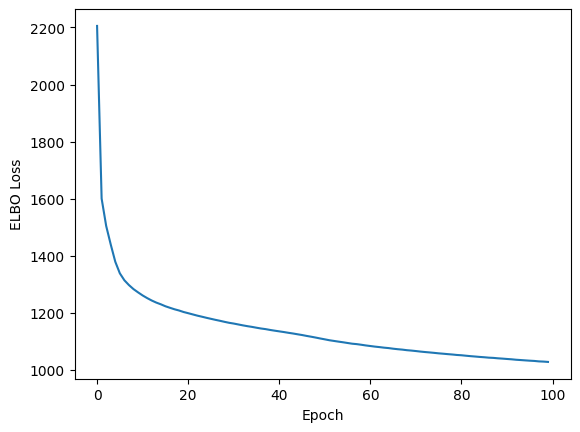

In [26]:
# Plot the ELBO Loss over training
plt.plot(elbo2)
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.show()

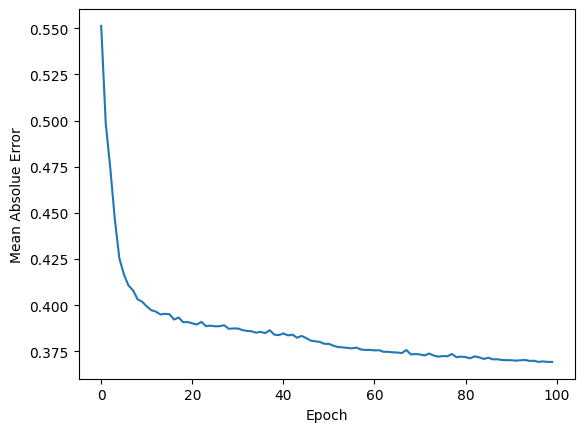

In [27]:
# Plot error over training
plt.plot(mae2)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolue Error')
plt.show()